In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd

file_path = "/content/drive/MyDrive/데이터분석/insurance.csv"
df = pd.read_csv(file_path)

df.head()



,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


데이터 크기 (행, 열): (1338, 7)

[결측치 확인]
smoker     0
charges    0
dtype: int64

[흡연 여부 분포]
smoker
no     1064
yes     274
Name: count, dtype: int64

[보험료(charges) 기초 통계]
count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64


<Figure size 700x500 with 0 Axes>

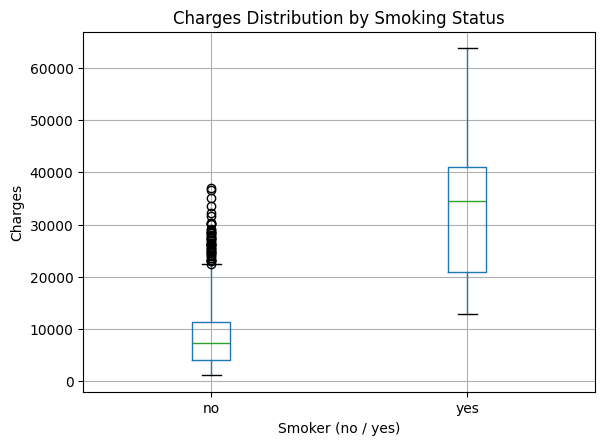

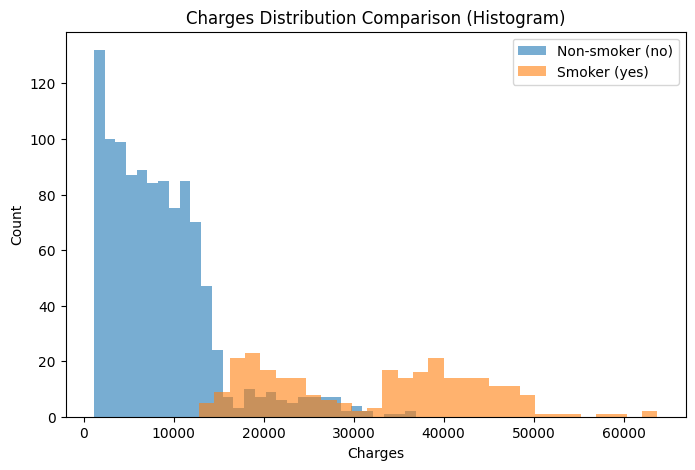


귀무가설(H₀): 흡연자와 비흡연자의 평균 보험료는 같다
대립가설(H₁): 흡연자의 평균 보험료가 비흡연자보다 높다

[집단별 요약 통계]
Non-smoker (no): n=1064, mean=8,434.27, std=5,993.78
Smoker (yes):   n=274, mean=32,050.23, std=11,541.55
Mean difference (yes - no): 23,615.96

[t-test 결과]
t-statistic: 32.7519
two-sided p-value: 5.88946e-103
one-sided p-value (Smoker > Non-smoker): 2.94473e-103

[p-value 범주 해석]
p-value < 0.001 (매우 유의미)

[p-value 해석]
p-value < 0.05 → 귀무가설을 기각한다.

[효과 크기] Cohen's d = 3.1613


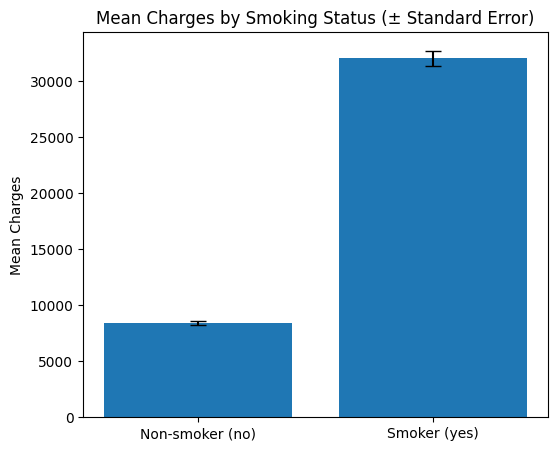

In [9]:
# ============================================================
# 가설1 검정:
# "흡연자는 비흡연자보다 보험료(charges)가 높을 것이다"
# (그래프 축/라벨은 영어로 표기)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# ------------------------------------------------------------
# 0) 사전 점검 및 데이터 정리
# ------------------------------------------------------------

# 필요한 컬럼 확인
required_cols = {"smoker", "charges"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"필수 컬럼이 없습니다: {missing}")

# 데이터 정리
df = df.copy()
df["smoker"] = df["smoker"].astype(str).str.strip().str.lower()
df["charges"] = pd.to_numeric(df["charges"], errors="coerce")

# 분석에 필요한 컬럼 결측치 제거
df = df.dropna(subset=["smoker", "charges"])
df = df[df["smoker"].isin(["yes", "no"])]

# ------------------------------------------------------------
# 1) 데이터 탐색(EDA) 및 문제 정의
# ------------------------------------------------------------

print("데이터 크기 (행, 열):", df.shape)

print("\n[결측치 확인]")
print(df[["smoker", "charges"]].isnull().sum())

print("\n[흡연 여부 분포]")
print(df["smoker"].value_counts())

print("\n[보험료(charges) 기초 통계]")
print(df["charges"].describe())

# ------------------------------------------------------------
# 2) 시각화
# ------------------------------------------------------------

# 시각화 1: 흡연 여부에 따른 보험료 분포(Boxplot)
plt.figure(figsize=(7, 5))
df.boxplot(column="charges", by="smoker")
plt.title("Charges Distribution by Smoking Status")
plt.suptitle("")
plt.xlabel("Smoker (no / yes)")
plt.ylabel("Charges")
plt.show()

# 시각화 2: 히스토그램으로 분포 비교
charges_no = df.loc[df["smoker"] == "no", "charges"].to_numpy()
charges_yes = df.loc[df["smoker"] == "yes", "charges"].to_numpy()

plt.figure(figsize=(8, 5))
plt.hist(charges_no, bins=30, alpha=0.6, label="Non-smoker (no)")
plt.hist(charges_yes, bins=30, alpha=0.6, label="Smoker (yes)")
plt.title("Charges Distribution Comparison (Histogram)")
plt.xlabel("Charges")
plt.ylabel("Count")
plt.legend()
plt.show()

# ------------------------------------------------------------
# 3) 가설의 검증: 독립표본 t-test (Welch)
# ------------------------------------------------------------

print("\n귀무가설(H₀): 흡연자와 비흡연자의 평균 보험료는 같다")
print("대립가설(H₁): 흡연자의 평균 보험료가 비흡연자보다 높다")

# 집단별 통계 요약
mean_no = charges_no.mean()
mean_yes = charges_yes.mean()

std_no = charges_no.std(ddof=1)
std_yes = charges_yes.std(ddof=1)

n_no = len(charges_no)
n_yes = len(charges_yes)

print("\n[집단별 요약 통계]")
print(f"Non-smoker (no): n={n_no}, mean={mean_no:,.2f}, std={std_no:,.2f}")
print(f"Smoker (yes):   n={n_yes}, mean={mean_yes:,.2f}, std={std_yes:,.2f}")
print(f"Mean difference (yes - no): {mean_yes - mean_no:,.2f}")

# Welch의 t-test (분산이 다를 수 있으므로 equal_var=False)
t_stat, p_two = ttest_ind(charges_yes, charges_no, equal_var=False)

# 단측 검정 p-value 계산 (흡연자 > 비흡연자)
p_one = p_two / 2 if t_stat > 0 else 1 - (p_two / 2)

print("\n[t-test 결과]")
print(f"t-statistic: {t_stat:.4f}")
print(f"two-sided p-value: {p_two:.6g}")
print(f"one-sided p-value (Smoker > Non-smoker): {p_one:.6g}")

# ------------------------------------------------------------
# ⭐ p-value를 이해하기 쉬운 구간으로 표현
# ------------------------------------------------------------

print("\n[p-value 범주 해석]")
if p_one < 0.001:
    print("p-value < 0.001 (매우 유의미)")
elif p_one < 0.05:
    print("p-value < 0.05 (유의미)")
else:
    print("p-value ≥ 0.05 (유의미하지 않음)")

alpha = 0.05

print("\n[p-value 해석]")
if p_one < alpha:
    print(f"p-value < {alpha} → 귀무가설을 기각한다.")
else:
    print(f"p-value ≥ {alpha} → 귀무가설을 기각할 수 없다.")


# ------------------------------------------------------------
# 4) 효과 크기(Cohen's d) + 평균 비교 시각화
# ------------------------------------------------------------

# 효과 크기(Cohen's d) 계산
pooled_sd = np.sqrt(
    ((n_yes - 1) * std_yes**2 + (n_no - 1) * std_no**2) / (n_yes + n_no - 2)
)
cohens_d = (mean_yes - mean_no) / pooled_sd
print(f"\n[효과 크기] Cohen's d = {cohens_d:.4f}")

# 시각화 3: 평균 비교 그래프 (표준오차 포함)
se_no = std_no / np.sqrt(n_no)
se_yes = std_yes / np.sqrt(n_yes)

plt.figure(figsize=(6, 5))
plt.bar(
    ["Non-smoker (no)", "Smoker (yes)"],
    [mean_no, mean_yes],
    yerr=[se_no, se_yes],
    capsize=6
)
plt.title("Mean Charges by Smoking Status (± Standard Error)")
plt.ylabel("Mean Charges")
plt.show()
